# Working with sequence data.

### This notebook helps to understand how to work with sequence time-series data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.4.0


## Helper Function for visualization

In [2]:
def plot_graph(type_of_graph, time, series):
    plt.figure()
    plt.plot(time, series)
    plt.title('Visualizing {}'.format(type_of_graph))
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

In [3]:
def plot_forecast_valid(validation_time, prediction_data, validation_data):
    plt.figure()
    plt.plot(validation_time, results, label = 'prediction')
    plt.plot(validation_time, x_validation, label = 'validation')
    plt.title('Validation vs Predication data')
    plt.xlabel('Value')
    plt.ylabel('Time')
    plt.grid(True)
    plt.legend()
    plt.show()

## 1. Basics:
### Trend, Seasonality & Noise.
#### Equations :
    1. trend : return time*slope
    2. seasonality :
        season_time = ((time*phase) % period) / period
        seasonality = season_time < threshold? return Cos(season_time*2*pi) : return 1/ exp(3*season_time)
        return amplitude*seasonality
    3. noise : return random_number*noise_level   
    4. time_series_data = trend + seasonality + noise

In [4]:
def trend(time, slope = 0):
    return time*slope
def seasonality(time, amplitude, period, phase=0,  threshold=0.4):
    season_time = ((time+phase) % period) / period
    seasonality = np.where(season_time<threshold, np.cos(season_time*2*np.pi), 1/np.exp(3*season_time))
    return seasonality*amplitude
def noise(time, noise_level = 1, seed = 1):
    randomality = np.random.RandomState(seed).randn(len(time))
    return randomality*noise_level

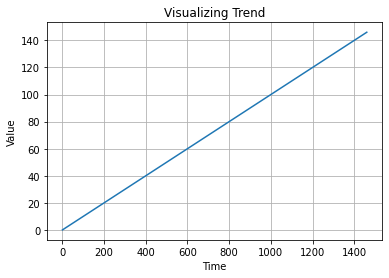

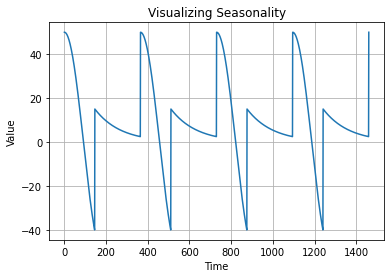

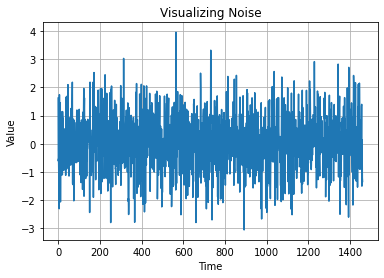

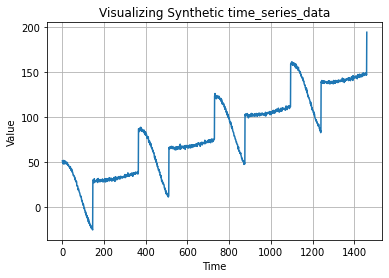

In [5]:
time = np.arange(4*365+1)
amplitude = 50
period = 365

series1 = trend(time, slope=0.1)
plot_graph('Trend', time, series1)

series2 = seasonality(time, amplitude, period)
plot_graph('Seasonality', time, series2)

series3 = noise(time)
plot_graph('Noise', time, series3)

time_series_data = trend(time, slope=0.1) + seasonality(time, amplitude, period) + noise(time)
plot_graph('Synthetic time_series_data', time, time_series_data)

## 2. Applying the Basics.
### a. Creating a Dataset.

In [6]:
print('creating a normal dataset:')
import tensorflow as tf
dataset = tf.data.Dataset.range(10)

for val in dataset:
    print(val.numpy())
    
print('\ncreating window for sequence data:')
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1)
for window_set in dataset:
    for val in window_set:
        print(val.numpy(), end = ' ')
    print() 

print("\nFixing the problem with 'drop_remainder': ")
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder = True)
for window_set in dataset:
    for val in window_set:
        print(val.numpy(), end = ' ')
    print()

creating a normal dataset:
0
1
2
3
4
5
6
7
8
9

creating window for sequence data:
0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 

Fixing the problem with 'drop_remainder': 
0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


### b. Preprocessing Seqeunce Dataset.
#### Create a helper function that will proprocess series data.
##### Steps:
1. We will create a Dataset first.We will pass a series_data using the from_tensor_slices() method.It will return a dataset.
2. Using the window method, we will create time window of certain size for sequence data.
3. then we will flatten the input data.
4. We will then shuffle to reduce sequence bias.
5. We can map the inputs in a batch using the map method.
6. We will then create 2 batches of xs and ys. The prefetch improves latency.

In [7]:
def windowed_dataset(series_data, window_size, random_buffer_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series_data)
    dataset = dataset.window(window_size+1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(random_buffer_size)
    dataset = dataset.map(lambda window : (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

series_data = np.arange(10)
data = windowed_dataset(series_data, window_size=5, random_buffer_size=4, batch_size=1)
for x,y in data:
    print('x = {},  y = {}\n'.format(x.numpy(), y.numpy()))

x = [[2 3 4 5 6]],  y = [[7]]

x = [[1 2 3 4 5]],  y = [[6]]

x = [[4 5 6 7 8]],  y = [[9]]

x = [[0 1 2 3 4]],  y = [[5]]

x = [[3 4 5 6 7]],  y = [[8]]



### c. Putting Everything Together with NN.

##### Steps-
1. Create Dataset.
2. Split Dataset.
3. Create windowed Trainset.
4. Build, Compile and train the model.
5. Predict.

In [8]:
tf.keras.backend.clear_session
# creating a time and a series
time = np.arange(16)
series_data = time

# splitting into train_set and validation_set
split_time = 10
x_train = series_data[:split_time]
time_train = time[:split_time]
x_valid = series_data[split_time:]
time_valid = time[split_time:]

# creating window_dataset
window_size=5
train_dataset = windowed_dataset(x_train, window_size, random_buffer_size=1, batch_size=1)
# for x,y in train_dataset:
#     print('dataset')
#     print('x = {} , y = {}\n'.format(x.numpy(), y.numpy()))
# model build,compile & train
model = tf.keras.Sequential(tf.keras.layers.Dense(1, input_shape=[window_size]))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_dataset, epochs=1000, verbose=0)

# model predict
print('Series data : {}'.format(series_data))
forecast = []
for t in range(len(series_data) - window_size):
    predict = model.predict(series_data[t:t+window_size].reshape(1,-1))
    print('input data = {}, \t predicted data = {}'.format(series_data[t:t+window_size], predict))
    forecast = np.append(forecast, predict)

Series data : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
input data = [0 1 2 3 4], 	 predicted data = [[5.00279]]
input data = [1 2 3 4 5], 	 predicted data = [[6.003358]]
input data = [2 3 4 5 6], 	 predicted data = [[7.003925]]
input data = [3 4 5 6 7], 	 predicted data = [[8.004493]]
input data = [4 5 6 7 8], 	 predicted data = [[9.00506]]
input data = [5 6 7 8 9], 	 predicted data = [[10.005628]]
input data = [ 6  7  8  9 10], 	 predicted data = [[11.006195]]
input data = [ 7  8  9 10 11], 	 predicted data = [[12.0067625]]
input data = [ 8  9 10 11 12], 	 predicted data = [[13.00733]]
input data = [ 9 10 11 12 13], 	 predicted data = [[14.007897]]
input data = [10 11 12 13 14], 	 predicted data = [[15.008465]]


## 3. Working With Synthetic time-series dataset.
### a. Using Single-NN.

In [9]:
# creating synthetics data
time = np.arange(4*365+1)
amplitude = 50
period = 365
window_size=20
series_data = trend(time, slope=0.1) + seasonality(time, amplitude, period) + noise(time)

#splitting the time and series data for training and validation
split_time = 1000
time_train = time[:split_time]
x_train = series_data[:split_time]
time_valid = time[split_time:]
x_valid = series_data[split_time:]

# creating windowed dataset 
dataset = windowed_dataset(x_train, window_size, batch_size=32, random_buffer_size=1000)

# build model
l0 = tf.keras.layers.Dense(1, input_shape = [window_size]) #same as window size
model_snn = tf.keras.Sequential([l0])
# print(l0.get_weights())

# compile model
model_snn.compile(loss = 'mse', optimizer = tf.keras.optimizers.SGD(lr = 1e-06, momentum = 0.9))

# train model
history_snn = model_snn.fit(dataset, epochs=500, verbose=0)

In [10]:
# plot function
def plot_history(loss):
    plt.plot(loss)
    plt.title('Visualization of Loss ')
    plt.xlabel('No of epochs')
    plt.ylabel('Loss')
    plt.show()

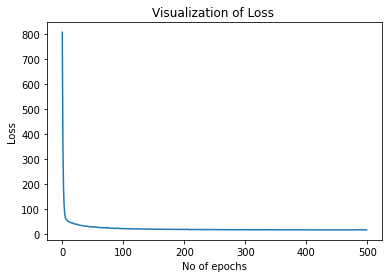

In [11]:
loss_snn = history_snn.history['loss']
plot_history(loss_snn)

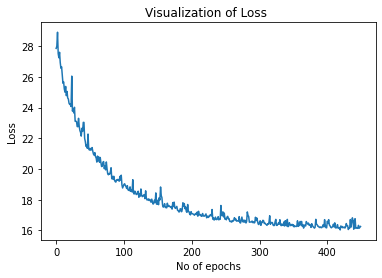

In [12]:
# for better understanding , we will ignore the first 50 values
loss_snn50 = history_snn.history['loss'][50:]
plot_history(loss_snn50)

#### Forecasting
**Understanding the code:**

1. **[split-time-window_size]**     Assume we have , series input=[0 ,1, 2, 3, 4, 5,...9], window_size=3, split_time=3 and our network just do input=output. So the output of input should be output=[3, 4, 5, ...,9]. And you can see the index start at 3 correspondings to the input, but if you want to get any number from the output you should do input[split-time-window_size]
    <br><br>If you do model.summary(), you will see that the input is a single dense layer.  You can do model.layers[0].shape to get the shape of the input layer to the model.  In this case you will get (None,20).  

2. **series[time : time + window_size][np.newaxis]**: It is a bit of an obscure way of turning 1D array into 2D array. The canonical way of doing it in numpy would be : **series[time:time + window_size].reshape(1, -1)** <br><br> The reason we are doing it is that model.predict() expects an array of samples and will return an array of predictions. Our samples themselves are arrays of window_size length. So, with the above code we have turned our slice of series into an array with one element, which is itself an array of size window_size.

    **Explanation** :If you do model.summary(), you will see that the input is a single dense layer.  You can do model.layers[0].shape to get the shape of the input layer to the model.  In this case you will get (None,20).  tf.model actually adds the batch_size as the first dimension the input for you, so you need to exclude the batch size with you specify the inout_shape for the first layer in your model.Now in the model.predict() function input shape should match that of the input layer (None, 20).  The input in this case is the windowed dataset of shape (20) - if you print series[time:time + window_size].shape, that is what you see.  There is order to reshape the input to the expected input_shape, you need to use np.newaxis to add the extra dimension.  If you print (series[time:time + window_size][np.newaxis]).shape, you will now get (1,20), which is what is expected.
    
    **numpy.newaxis**: It is used to increase the dimension of the existing array by one more dimension, when used once. 1D array will become 2D array, 2D array will become 3D array


3. **np.array(forecast)[:, 0, 0]**: It is an even more obscure way of flattening an array. Again, the canonical way of doing it in numpy is: **np.array(forecast).flatten()** <br> <br>
    The reason why we have to do this is that, as model.predict() returns an array of predictions. Each prediction is in itself an array (with single element in our case). Next, we add them all to the forecast array as elements and we end up with a 3D array, which needs to be flattened. <br><br>
    One way to simplify this is to use **np.append()** instead, which will flatten the array automagically.
    
    


In [13]:
#snn forecast
forecast_snn = []
split_time = 1000
window_size = 20
for time in range(len(series_data)-window_size):
    prediction = model_snn.predict(series_data[time : time+window_size].reshape(1, -1))
    forecast_snn = np.append(forecast_snn, prediction)
result_snn = forecast_snn[split_time-window_size :]

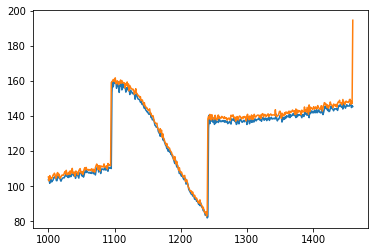

In [14]:
plt.plot(time_valid, result_snn)
plt.plot(time_valid, x_valid)
plt.show()

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, result_snn).numpy()

2.2847780782655733

### b(i). Using Deep-NN.

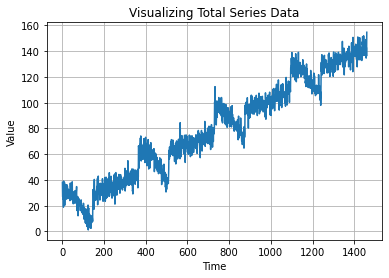

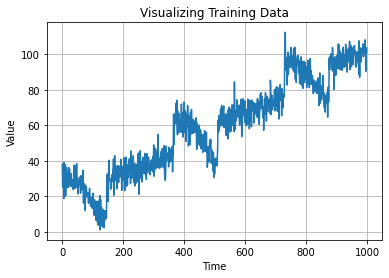

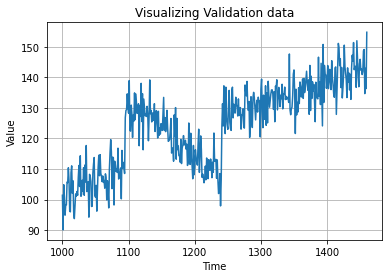

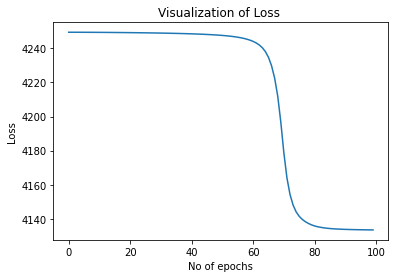

In [16]:
# pre-processing series data
time = np.arange(4*365+1)
baseline, amplitude, period, slope, noise_level, seed = 10, 20, 365, 0.09, 5, 42
series_data = baseline + trend(time, slope) + seasonality(time, amplitude, period) + noise(time, noise_level)
plot_graph('Total Series Data', time,  series_data)

split_time = 1000
time_train = time[:split_time]
x_train = series_data[:split_time]
time_valid = time[split_time:]
x_valid = series_data[split_time:]

plot_graph('Training Data', time_train, x_train)
plot_graph('Validation data', time_valid, x_valid)

# creating windowed data
window_size, batch_size, random_buffer_size = 20, 32, 1000
dataset = windowed_dataset(x_train, window_size, batch_size, random_buffer_size)

# creating model
model_dnn1 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
# compile model
model_dnn1.compile(loss = 'mse', optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum = 0.9))
# train model
history_dnn1 = model_dnn1.fit(dataset, epochs=100, verbose=0)

loss_dnn1 = history_dnn1.history['loss']
plot_history(loss_dnn1)
plt.show()

### b(ii). Deep NN [ Using callbacks]

In [17]:
#preprocessing data
time = np.arange(4*365+1)
baseline, amplitude, period, slope, noise_level, seed = 10, 20, 365, 0.09, 5, 42
series_data = baseline + trend(time, slope) + seasonality(time, amplitude, period) + noise(time, noise_level)

# splitting
split_time = 1000
time_train = time[:split_time]
x_train = series_data[:split_time]
time_valid = time[split_time:]
x_valid = series_data[split_time:]

# windowed dataset
window_size, random_buffer_size, batch_size = 20, 1000, 32
dataset = windowed_dataset(x_train, window_size, random_buffer_size, batch_size)

# model build, compile, train
model_dnn2 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8* 10**(epoch/20))
model_dnn2.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr = 1e-8, momentum=0.9))
history_dnn2 = model_dnn2.fit(dataset, epochs =100, verbose=0, callbacks = [lr_scheduler])

In [18]:
# # now we will plot the loss vs leraning rates to get the optimal lr
# lrs = 1e-8 * 10**(np.arange(100)/20)
# loss = history_dnn2.history['loss']
# plt.semilogx(lrs, loss)
# plt.axis([1e-8, 1e-3, 0, 300])

### b(iii). Deep NN [ Using optimal values only]

In [19]:
window_size, random_buffer_size, batch_size = 20, 1000, 32
dataset = windowed_dataset(x_train, window_size, random_buffer_size, batch_size)

# model build, compile, train
model_dnn3 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])
model_dnn3.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr = 5e-6, momentum=0.9))
history_dnn3 = model_dnn3.fit(dataset, epochs=100, verbose=0)

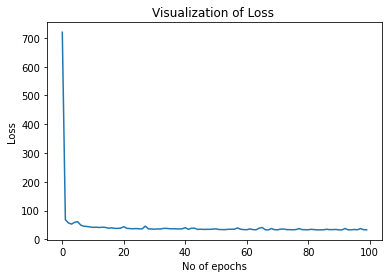

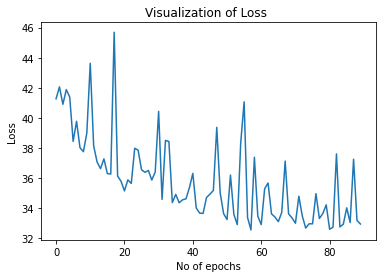

In [20]:
loss_dnn3 = history_dnn3.history['loss']
plot_history(loss_dnn3)
loss_dnn3_but10 = loss_dnn3[10:]
plot_history(loss_dnn3_but10)

In [21]:
forecast_dnn = []
for t in range(len(series_data) -window_size):
    prediction = model_dnn3.predict(series_data[t:t+window_size].reshape(1,-1))
    forecast_dnn = np.append(forecast_dnn, prediction)
result_dnn3 = forecast_dnn[split_time-window_size:]

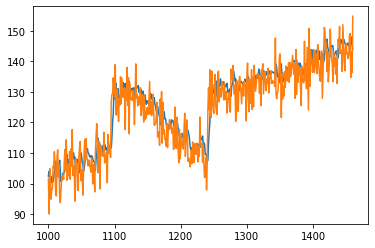

In [22]:
plt.plot(time_valid, result_dnn3)
plt.plot(time_valid, x_valid)
plt.show()

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, result_dnn3).numpy()

4.916458598200904

### c. Using Simple-RNN.

#### Sanity check:
    We will plot to get the learning rate value using the learning rate scheduler callbacks. After plotting , we will remove them for loss computation. Also we will check and change the epoch. 

In [24]:
# hyperparams
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# series and time data
time = np.arange(4 * 365 + 1, dtype="float32")
series_data = baseline + trend(time, slope) + seasonality(time, amplitude, period) + noise( time, noise_level)

# splitting
split_time = 1000
x_train = series_data[:split_time]
time_train = time[:split_time]
x_valid = series_data[split_time:]
time_valid = time[split_time:]

# creating windowed datset
window_size, random_buffer_size, batch_size = 20, 1000, 128
trainset = windowed_dataset(x_train, window_size, random_buffer_size, batch_size)

# model build, compile and train
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model_rnn.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9),metrics=["mae"])
history_rnn = model_rnn.fit(trainset, epochs=400, verbose=0)

In [25]:
# # sanity check
# #history_srnn.history.keys()
# plt.semilogx(history_rnn.history['lr'],history_rnn.history['loss'])
# plt.axis([1e-8, 1e-4, 0, 30])
# plt.show()

In [26]:
# forecasting
forecast_rnn = []
for t in range(len(series_data)-window_size):
    predict_rnn = model_rnn.predict(series_data[t:t+window_size].reshape(1,-1))
    forecast_rnn = np.append(forecast_rnn, predict_rnn)
result_rnn = forecast_rnn[split_time-window_size:]

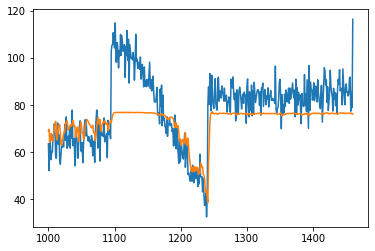

In [27]:
plt.plot(time_valid, x_valid)
plt.plot(time_valid, result_rnn)
plt.show()

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, result_rnn).numpy()

9.265825864470461

### d. Using LSTM.

#### Sanity check:
    We will plot to get the learning rate value using the learning rate scheduler callbacks. After plotting , we will remove them for loss computation. Also we will check and change the epoch.

In [29]:
# hyperparams
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# series and time data
time = np.arange(4 * 365 + 1, dtype="float32")
series_data = baseline + trend(time, slope) + seasonality(time, amplitude, period) + noise( time, noise_level)

# splitting
split_time = 1000
x_train = series_data[:split_time]
time_train = time[:split_time]
x_valid = series_data[split_time:]
time_valid = time[split_time:]

# creating windowed datset
window_size, random_buffer_size, batch_size = 20, 1000, 32
trainset = windowed_dataset(x_train, window_size, random_buffer_size, batch_size)

# model build, compile and train
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model.compile(loss='mse', optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history_lstm = model.fit(trainset, epochs=500, verbose=0)

In [30]:
# # sanity check
# plt.semilogx(history_lstm.history['lr'], history_lstm.history['loss'])
# plt.axis(1e-8, 1e-4, 0, 30)

In [31]:
forecast_lstm = []
for t in range(len(series_data)-window_size):
    predict = model.predict(series_data[t:t+window_size].reshape(1,-1))
    forecast_lstm = np.append(forecast_lstm, predict)
result_lstm = forecast_lstm[split_time-window_size:]

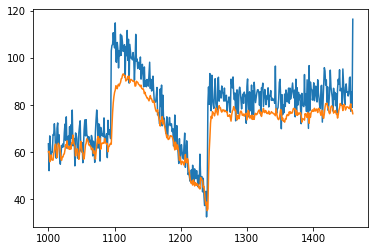

In [32]:
plt.plot(time_valid, x_valid)
plt.plot(time_valid, result_lstm)
plt.show()

In [33]:
tf.keras.metrics.mean_absolute_error(x_valid, result_lstm).numpy()

7.502411713703865

## e. Using a combination of Conv1D & LSTM.

In [ ]:
tf.keras.backend.clear_session
# hyperparams
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# series and time data
time = np.arange(4 * 365 + 1, dtype="float32")
series_data = baseline + trend(time, slope) + seasonality(time, amplitude, period) + noise( time, noise_level)

# splitting
split_time = 1000
x_train = series_data[:split_time]
time_train = time[:split_time]
x_valid = series_data[split_time:]
time_valid = time[split_time:]

# windowed dataset
window_size, random_buffer_size, batch_size = 20, 1000, 32
trainset = windowed_dataset(x_train, window_size, random_buffer_size, batch_size)

# model build , compile and run
model_combo = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1,
                          padding='causal', activation='relu', input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x*100)
])
model_combo.compile(loss=tf.keras.losses.Huber(),
             optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),
             metrics=['mae'])
history_combo = model_combo.fit(trainset, epochs=500, verbose=0)

In [ ]:
forecasting_combo = []
for t in range(len(series_data)-window_size):
    prediction_combo = model_combo.predict(series_data[t:t+window_size].reshape(1,-1))
    forecasting_combo = np.append(forecasting_combo, prediction_combo)
result_combo = forecasting_combo[split_time-window_size:]

In [ ]:
plt.plot(time_valid, x_valid)
plt.plot(time_valid, result_combo)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, result_combo).numpy()

## 4. Working with Real-life Time-Series Data. [Sunspot Dataset]

### a. Using DNN.

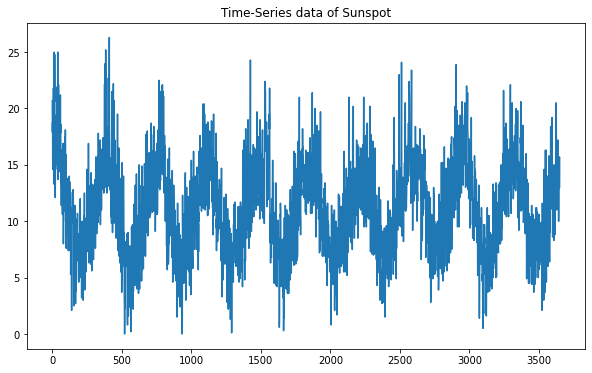

In [59]:
import pandas as pd
data = pd.read_csv('daily-min-temperatures.csv')
time = data.index.values
series_data = data['Temp'].values
plt.figure(figsize=(10,6))
plt.plot(time, series_data)
plt.title('Time-Series data of Sunspot')
plt.show()

# splitting
split_time = 3000
x_train = series_data[:split_time]
time_train = time[:split_time]
x_valid = series_data[split_time:]
time_valid = time[split_time:]


# creating windowed data
window_size, random_buffer_size, batch_size = 60, 1000, 1000
trainset = windowed_dataset(x_train, window_size, random_buffer_size, batch_size)

# model build, compile and train
model_sun = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])
model_sun.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
history_sun = model_sun.fit(trainset, epochs=100, verbose=0)

In [53]:
forecast_sunspot = []
for t in range(len(series_data)-window_size):
    predict_sun = model_sun.predict(series_data[t:t+window_size].reshape(1,-1))
    forecast_sunspot = np.append(forecast_sunspot, predict_sun)
result_sun = forecast_sunspot[split_time-window_size:]

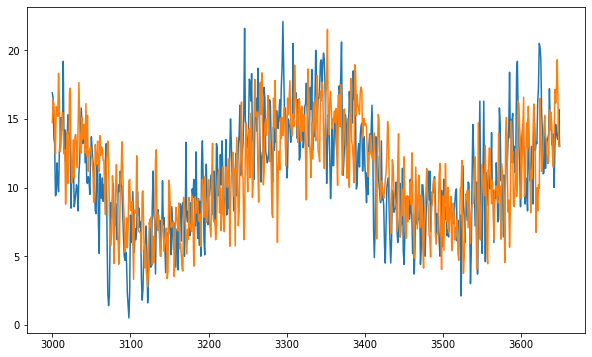

In [60]:
plt.figure(figsize=(10,6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, result_sun)
plt.show()

In [61]:
tf.keras.metrics.mean_absolute_error(x_valid, result_sun).numpy()

2.7570674056273243

### b. using combination of conv1D

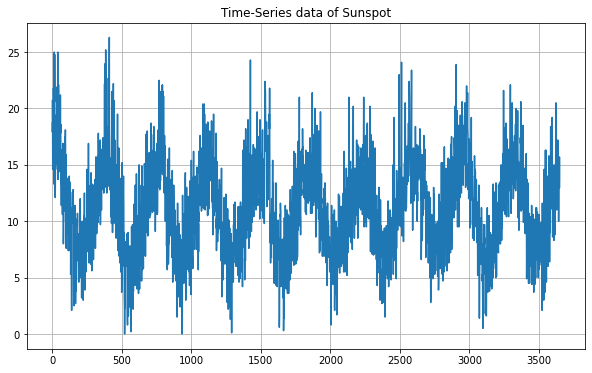

In [70]:
import pandas as pd
data = pd.read_csv('daily-min-temperatures.csv')
time = data.index.values
series_data = data['Temp'].values
plt.figure(figsize=(10,6))
plt.plot(time, series_data)
plt.title('Time-Series data of Sunspot')
plt.grid(True)
plt.show()

# splitting
split_time = 3000
x_train = series_data[:split_time]
time_train = time[:split_time]
x_valid = series_data[split_time:]
time_valid = time[split_time:]


# creating windowed data
window_size, random_buffer_size, batch_size = 60, 1000, 100
trainset = windowed_dataset(x_train, window_size, random_buffer_size, batch_size)

# model build, compile and train
model_sun2 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=-1)),
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda( lambda x: x*100)
])
model_sun2.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9), metrics=["mae"])
history_sun2 = model_sun2.fit(trainset, epochs=150, verbose=0)

In [76]:
data = pd.read_csv('daily-min-temperatures.csv')
series_data = data['Temp'].values
split_time = 3000
window_size = 60

forecast_sunspot2 = []
for t in range(len(series_data)-window_size):
    predict_sun2 = model_sun2.predict(series_data[t:t+window_size].reshape(1,-1))
    forecast_sunspot2 = np.append(forecast_sunspot2, predict_sun2)
result_sun2 = forecast_sunspot2[split_time-window_size:]

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, result_sun2)
plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, result_sun2).numpy()